In [1]:
%pylab inline
plt.rc('font',size=20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from perceptionneuron import *
from perceptionneuron.experiment import logistic,ilogistic

def retrain_gpr(trial):
    """Retrain gprmodels using polar coordinate system.
    v3 experiments learned landscape using a grid of (t,f) values.
    """
    f = trial.gprmodel.fractions
    t = trial.gprmodel.durations
    c = trial.gprmodel.coherences

    gpr = GPR()
    gpr.durations = t
    gpr.fractions = f
    gpr.coherences = c
    gpr.gp.fit(vstack((t,f)).T,c)
    gpr.predict()
    
    trial.gprmodel = gpr

In [3]:
# Load v3.1 data.
trials3_1 = []
for i in xrange(5):
    trials3_1.append( VRTrial3_1(*subject_settings_v3_1(i)) )

# Retrain trials to use polar coordinate system.
for trial in trials3_1:
    retrain_gpr(trial)

In [4]:
# Show landscape for every person.
perfBySubject = zeros((len(trials3_1),10,16))
fractions,durations = arange(.1,1.1,.1),arange(.5,2.1,.1)
nFraction,nDuration = len(fractions),len(durations)
mesht,meshf = meshgrid(durations,fractions)
meshlist = vstack((mesht.ravel(),meshf.ravel())).T

for subjectIx in xrange(5):
    trial = trials3_1[subjectIx]
    p,_ = trial.gprmodel.predict(meshlist)
    p -= p.mean()
    p /= p.std()
    p = p.reshape(10,16)
    
    perfBySubject[subjectIx,:,:] = p

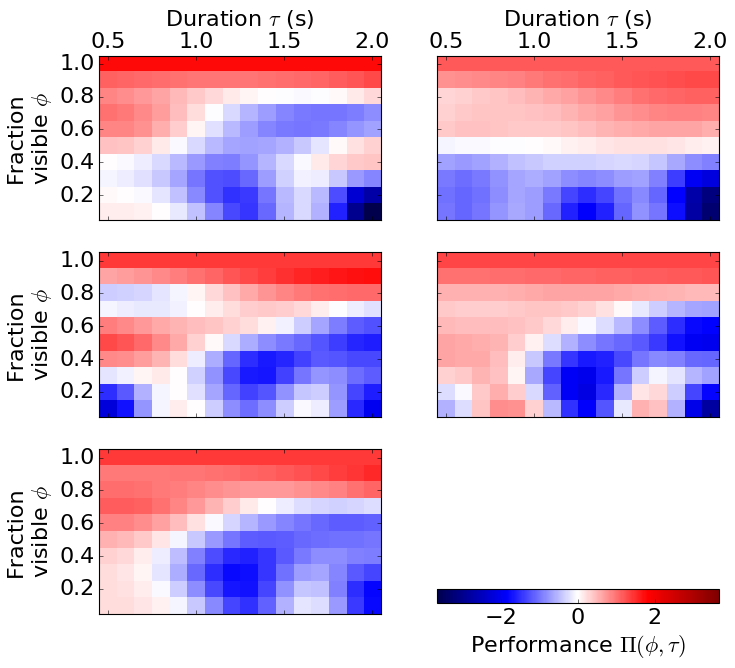

In [5]:
# Prediction of coherences.
mx = abs(perfBySubject).max()

fig,ax = plt.subplots(figsize=(10,9),ncols=2,nrows=3,sharey=True)
k = 0
for i in xrange(3):
    for j in xrange(2):
        if k>=len(perfBySubject):
            ax[i,j].set_visible(False)
        else:
            p = perfBySubject[k]
            cax = ax[i,j].matshow(p,cmap=plt.cm.seismic,zorder=0,vmin=-mx,vmax=mx,aspect='auto')
            ax[i,j].set(xlim=(-.5,nDuration-.5),ylim=(-.5,nFraction-.5),
                      xticks=range(0,17,5),yticks=range(1,12,2),
                      xticklabels=[],yticklabels=fractions[1::2]);
            if i==0:
                ax[i,j].xaxis.set_label_position('top')
                ax[i,j].set(xlabel=r'Duration $\tau$ (s)',xticklabels=durations[::5])
            if j==0:
                ax[i,j].set(ylabel='Fraction\n'+r'visible $\phi$')
        if k==5:
            cbarax = fig.colorbar(cax,ax=ax[i,j],orientation='horizontal',pad=.7)
            cbarax.set_ticks([-2,0,2])
            ax[i,j].get_position
            cbarax.set_label(r'Performance $\Pi(\phi,\tau)$')
        k += 1

# [L.set_rotation(90) for L in ax.xaxis.get_ticklabels()]
# fig.colorbar(cax,ax=ax,shrink=.9,label='z-Performance')

# Combine normalized data points into a single GPR.

In [92]:
fractions,durations,perf = [],[],[]
for trial in trials3_1:
    p = trial.gprmodel.coherences.copy()
    
    # Subtract off sample means.
    p -= p.mean()
    p /= p.std()
    
    # Subtract off GPR means.
#     p -= trial.gprmodel.coherence_pred.mean()
#     p /= trial.gprmodel.coherence_pred.std()
    
    perf.append( p )
    
    fractions.append( trial.gprmodel.fractions )
    durations.append( trial.gprmodel.durations )

perf = concatenate(perf)
fractions = concatenate(fractions)
durations = concatenate(durations)

In [93]:
nFraction=10
nDuration=16

In [94]:
combGprModel = GPR()
combGprModel.coherences = perf
combGprModel.fractions = fractions
combGprModel.durations = durations
combGprModel.predict()

avgPerfGrid = combGprModel.coherence_pred.reshape((nFraction,nDuration))

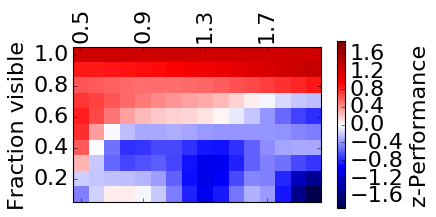

In [95]:
# Prediction of coherences. Ball
mx = abs(avgPerfGrid).max()

fig,ax = plt.subplots(figsize=(5,3))
cax = ax.matshow(avgPerfGrid,cmap=plt.cm.seismic,zorder=0,vmin=-mx,vmax=mx)
durations,fractions = unique(combGprModel.meshPoints[:,0]),unique(combGprModel.meshPoints[:,1])
ax.set(xlim=(-.5,nDuration-.5),ylim=(-.5,nFraction-.5),
       ylabel='Fraction visible',
       xticks=range(0,17,4),yticks=range(1,12,2),
       xticklabels=durations[::4],yticklabels=fractions[1::2])
[L.set_rotation(90) for L in ax.xaxis.get_ticklabels()]
fig.colorbar(cax,ax=ax,shrink=.9,label='z-Performance')

In [20]:
import dill
dill.dump({'mx':mx,'nDuration':nDuration,'nFraction':nFraction,'combGprModel':combGprModel},
            open('plotting/avg_perf_grid.p','wb'),-1)

## Add in v3 trials.

In [271]:
# Add in v3 trials.
fractions,durations,perf = [],[],[]
for trial in trials3_1:
    p = trial.gprmodel.coherences.copy()
    p -= trial.gprmodel.coherence_pred.mean()
    p /= trial.gprmodel.coherence_pred.std()
    perf.append( p )
    
    fractions.append( trial.gprmodel.fractions )
    durations.append( trial.gprmodel.durations )

perf = concatenate(perf)
fractions = concatenate(fractions)
durations = concatenate(durations)

for gprmodel in gprmodelsv3:
    p = gprmodel.coherences.copy()
    if not (isnan(p).any() or isinf(p).any()):
        p -= p.mean()
        p /= p.std()
        perf = concatenate((perf,p))

        fractions = concatenate((fractions,gprmodel.fractions))
        durations = concatenate((durations,gprmodel.durations))

In [272]:
combGprModel = GPR(alpha=.5)
combGprModel.coherences = perf
combGprModel.fractions = fractions
combGprModel.durations = durations
combGprModel.predict()

avgPerfGrid = combGprModel.coherence_pred.reshape((nFraction,nDuration))

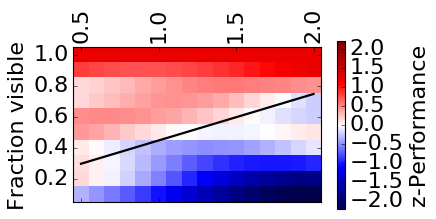

In [274]:
# Prediction of coherences combined with v3 Avatar trials.
mx = abs(avgPerfGrid).max()

fig,ax = plt.subplots(figsize=(5,3))
cax = ax.matshow(avgPerfGrid,cmap=plt.cm.seismic,zorder=0,vmin=-mx,vmax=mx)
durations,fractions = unique(gprmodel.meshPoints[:,0]),unique(gprmodel.meshPoints[:,1])
# ax.plot( (linspace(.5,2,10)-.5)*10, 1/(1-linspace(.1,1,10)),'k-',lw=2 )
# This makes sense because the more time we can't see the avatar, the worse we should perform.
ax.plot( (linspace(.5,2,10)-.5)*10, linspace(.1,1,10)*5+1.5,'k-',lw=2 )
ax.set(xlim=(-.5,nDuration-.5),ylim=(-.5,nFraction-.5),
       ylabel='Fraction visible',
       xticks=range(0,20,5),yticks=range(1,12,2),
       xticklabels=durations[::5],yticklabels=fractions[1::2])
[L.set_rotation(90) for L in ax.xaxis.get_ticklabels()]
fig.colorbar(cax,ax=ax,shrink=.9,label='z-Performance')

In [275]:
import dill
dill.dump({'mx':mx,'nDuration':nDuration,'nFraction':nFraction,'combGprModel':combGprModel},
            open('plotting/avg_perf_grid.p','wb'),-1)

# Construct grid of performance values for v3.0 experiments.

In [155]:
# Construct grid of performance values for v3.0 experiments.
dtwPerf = DTWPerformance()
def extract_perf_from_v3(trial,part='avatar'):
    fractions = []
    durations = []
    perf = []

    # Fully visible windows.
    for (_,at,av),(_,st,sv) in zip(trial.template_by_window_spec([(0,0)],part),
                                   trial.subject_by_window_spec([(0,0)],part)):
        if not ( isnan(sv).any() and isnan(av).any() ):
            fractions.append(1.)
            durations.append(0.)

            # Skip the first few seconds. These data are sampled at 60Hz so downsample to 30Hz.
            perf.append( dtwPerf.time_average(av[90::2],sv[90::2],dt=1/30) )

    # Blinking windows.
    for tau in arange(.7,1.3,.1):
        for phi in arange(.1,1.1,.1):  # fraction visible
            for (_,at,av),(_,st,sv) in zip(trial.template_by_window_spec([((1-phi)*tau,tau)],
                                                                         part,
                                                                         precision=.05),
                                           trial.subject_by_window_spec([((1-phi)*tau,tau)],
                                                                        part,
                                                                        precision=.05)):
                if not ( isnan(sv).any() and isnan(av).any() ) and ( len(av>500) and len(sv)>500 ):
                    fractions.append(phi)
                    durations.append(tau)

                    # Skip the first few seconds. These data are sampled at 60Hz so downsample to 30Hz.
                    perf.append( dtwPerf.time_average(av[90::2],sv[90::2],dt=1/30) )
    return fractions,durations,perf

In [217]:
gprmodelsv3 = []

for trial in trials3:
    fractions,durations,perf = extract_perf_from_v3(trial,'avatar')
    
    wellConditioned = True
    try:
        gprmodel = GPR(mean_performance=log(.44/.56))
        for f,t,p in zip(fractions,durations,perf):
            gprmodel.update(ilogistic(p),t,f)
    except AssertionError:
        wellConditioned = False
        
#     assert (gprmodel.std_pred>0j).all()
    if wellConditioned:
        gprmodelsv3.append(gprmodel)

In [218]:
nFraction = 10
nDuration = 16

In [219]:
avgPerfGrid = zeros((nFraction,nDuration))

counter = 0
for gpr in gprmodelsv3:
    perf = logistic(gpr.coherence_pred.reshape(nFraction,nDuration))
    if not isnan(perf).any():
        perf -= perf.mean()
        perf /= perf.std()
        avgPerfGrid += perf
        counter += 1
avgPerfGrid /= counter

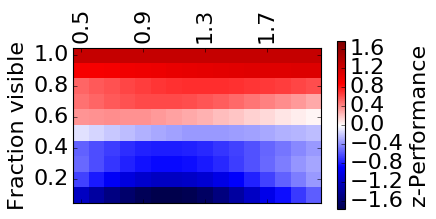

In [200]:
# Prediction of coherences. Ball
mx = abs(avgPerfGrid).max()

fig,ax = plt.subplots(figsize=(5,3))
cax = ax.matshow(avgPerfGrid,cmap=plt.cm.seismic,zorder=0,vmin=-mx,vmax=mx)
durations,fractions = unique(gprmodel.meshPoints[:,0]),unique(gprmodel.meshPoints[:,1])
ax.set(xlim=(-.5,nDuration-.5),ylim=(-.5,nFraction-.5),
       ylabel='Fraction visible',
       xticks=range(0,17,4),yticks=range(1,12,2),
       xticklabels=durations[::4],yticklabels=fractions[1::2])
[L.set_rotation(90) for L in ax.xaxis.get_ticklabels()]
fig.colorbar(cax,ax=ax,shrink=.9,label='z-Performance')

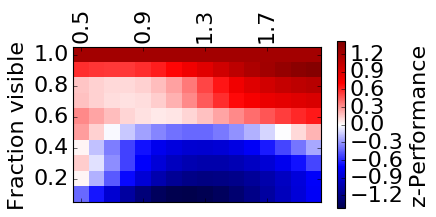

In [220]:
# Prediction of coherences. Avatar.
mx = abs(avgPerfGrid).max()

fig,ax = plt.subplots(figsize=(5,3))
cax = ax.matshow(avgPerfGrid,cmap=plt.cm.seismic,zorder=0,vmin=-mx,vmax=mx)
durations,fractions = unique(gprmodel.meshPoints[:,0]),unique(gprmodel.meshPoints[:,1])
ax.set(xlim=(-.5,nDuration-.5),ylim=(-.5,nFraction-.5),
       ylabel='Fraction visible',
       xticks=range(0,17,4),yticks=range(1,12,2),
       xticklabels=durations[::4],yticklabels=fractions[1::2])
[L.set_rotation(90) for L in ax.xaxis.get_ticklabels()]
fig.colorbar(cax,ax=ax,shrink=.9,label='z-Performance')